<a href="https://colab.research.google.com/github/Kira265/advances-self-supervised-models/blob/main/Advances_in_Self_supervised_Models_HW1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch torchvision torchaudio
!pip install thop
!pip install seaborn pandas

In [3]:
import torch
import torch.nn as nn
import time
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from torch.utils.benchmark import Timer

In [4]:
print("CUDA is available:", torch.cuda.is_available())
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU.")

CUDA is available: True
Using GPU: NVIDIA A100-SXM4-40GB


In [7]:
class SelfAttention(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.d_model = d_model
        self.query = nn.Linear(d_model, d_model)
        self.key = nn.Linear(d_model, d_model)
        self.value = nn.Linear(d_model, d_model)

    def forward(self, x):
        Q = self.query(x)
        K = self.key(x)
        V = self.value(x)

        attention_scores = torch.matmul(Q, K.transpose(-2, -1)) / torch.sqrt(torch.tensor(self.d_model, dtype=torch.float32))
        attention_probs = torch.nn.functional.softmax(attention_scores, dim=-1)

        return torch.matmul(attention_probs, V)

def count_flops(model, input_tensor):
    from thop import profile
    flops, _ = profile(model, inputs=(input_tensor,))
    return flops

def profile_self_attention(seq_lengths, d_model, num_runs=5, device='cpu'):
    results = {length: {'flops': [], 'memory': [], 'time': []} for length in seq_lengths}

    for length in seq_lengths:
        model = SelfAttention(d_model).to(device)
        input_tensor = torch.randn(1, length, d_model).to(device)

        for _ in range(num_runs):
            # FLOPS
            flops = count_flops(model, input_tensor)
            results[length]['flops'].append(flops)

            # Memory usage
            torch.cuda.reset_peak_memory_stats()
            _ = model(input_tensor)
            memory_usage = torch.cuda.max_memory_allocated() if device == 'cuda' else 0
            results[length]['memory'].append(memory_usage)

            # Wall clock time
            timer = Timer(stmt='model(input_tensor)', globals={'model': model, 'input_tensor': input_tensor})
            time_taken = timer.timeit(100).mean
            results[length]['time'].append(time_taken)

    return results

def plot_results(results, metric, ylabel, title):
    sns.set_style("whitegrid")
    plt.figure(figsize=(10, 6))

    x = list(results.keys())
    y = [np.mean(results[length][metric]) for length in x]
    yerr = [np.std(results[length][metric]) / np.sqrt(len(results[length][metric])) for length in x]

    sns.lineplot(x=x, y=y, marker='o')
    plt.fill_between(x, np.array(y) - np.array(yerr), np.array(y) + np.array(yerr), alpha=0.3)

    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Sequence Length')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

# Main execution
seq_lengths = [10, 100, 1000, 10000, 100000]
d_model = 4  # Reduced hidden dimension

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

results = profile_self_attention(seq_lengths, d_model, num_runs=5, device=device)

plot_results(results, 'flops', 'FLOPS', f'Computational Complexity (FLOPS) vs Sequence Length (d_model={d_model})')
plot_results(results, 'memory', 'Memory Usage (bytes)', f'Memory Usage vs Sequence Length (d_model={d_model})')
plot_results(results, 'time', 'Wall Clock Time (seconds)', f'Wall Clock Time vs Sequence Length (d_model={d_model})')

print("Profiling complete. Results plotted.")

Using device: cuda
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register count_linear() for <class 'torch.nn.modul

OutOfMemoryError: CUDA out of memory. Tried to allocate 37.25 GiB. GPU 0 has a total capacity of 39.56 GiB of which 1.42 GiB is free. Process 41341 has 38.14 GiB memory in use. Of the allocated memory 37.28 GiB is allocated by PyTorch, and 376.62 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

## 4.1 Build a Classifier

In [1]:
!pip install transformers datasets torch tqdm matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 55.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.0 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.


In [3]:
import torch
from torch.utils.data import DataLoader
from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW
from datasets import load_dataset
from tqdm import tqdm
import matplotlib.pyplot as plt

In [4]:
# Check for CUDA availability
if torch.cuda.is_available():
    try:
        torch.cuda.init()
        device = torch.device("cuda")
        print("CUDA is available. Using GPU.")
    except RuntimeError:
        print("CUDA initialization failed. Falling back to CPU.")
        device = torch.device("cpu")
else:
    print("CUDA is not available. Using CPU.")
    device = torch.device("cpu")

CUDA is available. Using GPU.


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
  1%|          | 50/4210 [00:17<24:36,  2.82it/s]

Step 50: Train Accuracy: 0.5659, Eval Accuracy: 0.5092


  2%|▏         | 100/4210 [00:53<24:18,  2.82it/s]

Step 100: Train Accuracy: 0.8898, Eval Accuracy: 0.8945


  4%|▎         | 150/4210 [01:28<23:58,  2.82it/s]

Step 150: Train Accuracy: 0.8705, Eval Accuracy: 0.8830


  5%|▍         | 200/4210 [02:03<23:40,  2.82it/s]

Step 200: Train Accuracy: 0.9091, Eval Accuracy: 0.9048


  6%|▌         | 250/4210 [02:38<23:22,  2.82it/s]

Step 250: Train Accuracy: 0.9011, Eval Accuracy: 0.9151


  7%|▋         | 300/4210 [03:13<23:05,  2.82it/s]

Step 300: Train Accuracy: 0.8795, Eval Accuracy: 0.8876


  8%|▊         | 350/4210 [03:49<22:49,  2.82it/s]

Step 350: Train Accuracy: 0.9045, Eval Accuracy: 0.9186


 10%|▉         | 400/4210 [04:24<22:29,  2.82it/s]

Step 400: Train Accuracy: 0.8943, Eval Accuracy: 0.8979


 11%|█         | 450/4210 [04:59<22:11,  2.82it/s]

Step 450: Train Accuracy: 0.9000, Eval Accuracy: 0.9083


 12%|█▏        | 500/4210 [05:34<21:53,  2.82it/s]

Step 500: Train Accuracy: 0.9023, Eval Accuracy: 0.8922


 13%|█▎        | 550/4210 [06:09<21:36,  2.82it/s]

Step 550: Train Accuracy: 0.9102, Eval Accuracy: 0.9186


 14%|█▍        | 600/4210 [06:44<21:19,  2.82it/s]

Step 600: Train Accuracy: 0.9170, Eval Accuracy: 0.9151


 15%|█▌        | 650/4210 [07:19<21:00,  2.82it/s]

Step 650: Train Accuracy: 0.9148, Eval Accuracy: 0.9163


 17%|█▋        | 700/4210 [07:55<20:44,  2.82it/s]

Step 700: Train Accuracy: 0.9148, Eval Accuracy: 0.9289


 18%|█▊        | 750/4210 [08:30<20:26,  2.82it/s]

Step 750: Train Accuracy: 0.9159, Eval Accuracy: 0.9151


 19%|█▉        | 800/4210 [09:05<20:09,  2.82it/s]

Step 800: Train Accuracy: 0.9011, Eval Accuracy: 0.9128


 20%|██        | 850/4210 [09:41<19:51,  2.82it/s]

Step 850: Train Accuracy: 0.9159, Eval Accuracy: 0.9174


 21%|██▏       | 900/4210 [10:16<19:33,  2.82it/s]

Step 900: Train Accuracy: 0.9170, Eval Accuracy: 0.9186


 23%|██▎       | 950/4210 [10:51<19:15,  2.82it/s]

Step 950: Train Accuracy: 0.9182, Eval Accuracy: 0.9220


 24%|██▍       | 1000/4210 [11:27<18:58,  2.82it/s]

Step 1000: Train Accuracy: 0.9193, Eval Accuracy: 0.9266


 25%|██▍       | 1050/4210 [12:02<18:40,  2.82it/s]

Step 1050: Train Accuracy: 0.9261, Eval Accuracy: 0.9186


 26%|██▌       | 1100/4210 [12:37<18:22,  2.82it/s]

Step 1100: Train Accuracy: 0.9318, Eval Accuracy: 0.9163


 27%|██▋       | 1150/4210 [13:13<18:05,  2.82it/s]

Step 1150: Train Accuracy: 0.9375, Eval Accuracy: 0.9197


 29%|██▊       | 1200/4210 [13:48<17:46,  2.82it/s]

Step 1200: Train Accuracy: 0.9318, Eval Accuracy: 0.9323


 30%|██▉       | 1250/4210 [14:23<17:28,  2.82it/s]

Step 1250: Train Accuracy: 0.9409, Eval Accuracy: 0.9197


 31%|███       | 1300/4210 [14:58<17:10,  2.82it/s]

Step 1300: Train Accuracy: 0.9284, Eval Accuracy: 0.9289


 32%|███▏      | 1350/4210 [15:34<16:53,  2.82it/s]

Step 1350: Train Accuracy: 0.9443, Eval Accuracy: 0.9220


 33%|███▎      | 1400/4210 [16:09<16:35,  2.82it/s]

Step 1400: Train Accuracy: 0.9318, Eval Accuracy: 0.9312


 34%|███▍      | 1450/4210 [16:44<16:18,  2.82it/s]

Step 1450: Train Accuracy: 0.9352, Eval Accuracy: 0.9278


 36%|███▌      | 1500/4210 [17:19<15:59,  2.82it/s]

Step 1500: Train Accuracy: 0.9420, Eval Accuracy: 0.9140


 37%|███▋      | 1550/4210 [17:54<15:44,  2.82it/s]

Step 1550: Train Accuracy: 0.9364, Eval Accuracy: 0.9266


 38%|███▊      | 1600/4210 [18:30<15:26,  2.82it/s]

Step 1600: Train Accuracy: 0.9182, Eval Accuracy: 0.9151


 39%|███▉      | 1650/4210 [19:05<15:08,  2.82it/s]

Step 1650: Train Accuracy: 0.9409, Eval Accuracy: 0.9232


 40%|████      | 1700/4210 [19:40<14:48,  2.82it/s]

Step 1700: Train Accuracy: 0.9307, Eval Accuracy: 0.9186


 42%|████▏     | 1750/4210 [20:15<14:31,  2.82it/s]

Step 1750: Train Accuracy: 0.9227, Eval Accuracy: 0.9278


 43%|████▎     | 1800/4210 [20:51<14:14,  2.82it/s]

Step 1800: Train Accuracy: 0.9432, Eval Accuracy: 0.9369


 44%|████▍     | 1850/4210 [21:26<13:56,  2.82it/s]

Step 1850: Train Accuracy: 0.9420, Eval Accuracy: 0.9278


 45%|████▌     | 1900/4210 [22:01<13:38,  2.82it/s]

Step 1900: Train Accuracy: 0.9466, Eval Accuracy: 0.9243


 46%|████▋     | 1950/4210 [22:37<13:21,  2.82it/s]

Step 1950: Train Accuracy: 0.9409, Eval Accuracy: 0.9300


 48%|████▊     | 2000/4210 [23:12<13:03,  2.82it/s]

Step 2000: Train Accuracy: 0.9307, Eval Accuracy: 0.9289


 49%|████▊     | 2050/4210 [23:48<12:45,  2.82it/s]

Step 2050: Train Accuracy: 0.9443, Eval Accuracy: 0.9278


 50%|████▉     | 2100/4210 [24:23<12:27,  2.82it/s]

Step 2100: Train Accuracy: 0.9398, Eval Accuracy: 0.9369


 51%|█████     | 2150/4210 [24:58<12:10,  2.82it/s]

Step 2150: Train Accuracy: 0.9432, Eval Accuracy: 0.9232


 52%|█████▏    | 2200/4210 [25:33<11:53,  2.82it/s]

Step 2200: Train Accuracy: 0.9534, Eval Accuracy: 0.9300


 53%|█████▎    | 2250/4210 [26:09<11:34,  2.82it/s]

Step 2250: Train Accuracy: 0.9432, Eval Accuracy: 0.9186


 55%|█████▍    | 2300/4210 [26:44<11:17,  2.82it/s]

Step 2300: Train Accuracy: 0.9545, Eval Accuracy: 0.9312


 56%|█████▌    | 2350/4210 [27:19<10:58,  2.82it/s]

Step 2350: Train Accuracy: 0.9614, Eval Accuracy: 0.9278


 57%|█████▋    | 2400/4210 [27:54<10:41,  2.82it/s]

Step 2400: Train Accuracy: 0.9477, Eval Accuracy: 0.9255


 58%|█████▊    | 2450/4210 [28:29<10:23,  2.82it/s]

Step 2450: Train Accuracy: 0.9557, Eval Accuracy: 0.9335


 59%|█████▉    | 2500/4210 [29:05<10:05,  2.82it/s]

Step 2500: Train Accuracy: 0.9500, Eval Accuracy: 0.9266


 61%|██████    | 2550/4210 [29:40<09:49,  2.82it/s]

Step 2550: Train Accuracy: 0.9545, Eval Accuracy: 0.9381


 62%|██████▏   | 2600/4210 [30:15<09:31,  2.82it/s]

Step 2600: Train Accuracy: 0.9568, Eval Accuracy: 0.9381


 63%|██████▎   | 2650/4210 [30:50<09:13,  2.82it/s]

Step 2650: Train Accuracy: 0.9455, Eval Accuracy: 0.9300


 64%|██████▍   | 2700/4210 [31:25<08:54,  2.82it/s]

Step 2700: Train Accuracy: 0.9545, Eval Accuracy: 0.9484


 65%|██████▌   | 2750/4210 [32:00<08:37,  2.82it/s]

Step 2750: Train Accuracy: 0.9489, Eval Accuracy: 0.9335


 67%|██████▋   | 2800/4210 [32:36<08:19,  2.82it/s]

Step 2800: Train Accuracy: 0.9568, Eval Accuracy: 0.9358


 68%|██████▊   | 2850/4210 [33:11<08:02,  2.82it/s]

Step 2850: Train Accuracy: 0.9330, Eval Accuracy: 0.9289


 69%|██████▉   | 2900/4210 [33:46<07:44,  2.82it/s]

Step 2900: Train Accuracy: 0.9568, Eval Accuracy: 0.9358


 70%|███████   | 2950/4210 [34:22<07:26,  2.82it/s]

Step 2950: Train Accuracy: 0.9420, Eval Accuracy: 0.9369


 71%|███████▏  | 3000/4210 [34:57<07:09,  2.82it/s]

Step 3000: Train Accuracy: 0.9625, Eval Accuracy: 0.9289


 72%|███████▏  | 3050/4210 [35:32<06:50,  2.82it/s]

Step 3050: Train Accuracy: 0.9580, Eval Accuracy: 0.9300


 74%|███████▎  | 3100/4210 [36:07<06:33,  2.82it/s]

Step 3100: Train Accuracy: 0.9409, Eval Accuracy: 0.9392


 75%|███████▍  | 3150/4210 [36:43<06:15,  2.82it/s]

Step 3150: Train Accuracy: 0.9602, Eval Accuracy: 0.9278


 76%|███████▌  | 3200/4210 [37:18<05:57,  2.82it/s]

Step 3200: Train Accuracy: 0.9614, Eval Accuracy: 0.9312


 77%|███████▋  | 3250/4210 [37:53<05:40,  2.82it/s]

Step 3250: Train Accuracy: 0.9386, Eval Accuracy: 0.9220


 78%|███████▊  | 3300/4210 [38:29<05:22,  2.82it/s]

Step 3300: Train Accuracy: 0.9591, Eval Accuracy: 0.9186


 80%|███████▉  | 3350/4210 [39:04<05:04,  2.82it/s]

Step 3350: Train Accuracy: 0.9591, Eval Accuracy: 0.9266


 81%|████████  | 3400/4210 [39:39<04:47,  2.82it/s]

Step 3400: Train Accuracy: 0.9511, Eval Accuracy: 0.9232


 82%|████████▏ | 3450/4210 [40:14<04:29,  2.82it/s]

Step 3450: Train Accuracy: 0.9534, Eval Accuracy: 0.9232


 83%|████████▎ | 3500/4210 [40:50<04:11,  2.82it/s]

Step 3500: Train Accuracy: 0.9500, Eval Accuracy: 0.9197


 84%|████████▍ | 3550/4210 [41:25<03:53,  2.82it/s]

Step 3550: Train Accuracy: 0.9477, Eval Accuracy: 0.9289


 86%|████████▌ | 3600/4210 [42:00<03:36,  2.82it/s]

Step 3600: Train Accuracy: 0.9489, Eval Accuracy: 0.9346


 87%|████████▋ | 3650/4210 [42:36<03:18,  2.82it/s]

Step 3650: Train Accuracy: 0.9545, Eval Accuracy: 0.9381


 88%|████████▊ | 3700/4210 [43:11<03:00,  2.82it/s]

Step 3700: Train Accuracy: 0.9477, Eval Accuracy: 0.9369


 89%|████████▉ | 3750/4210 [43:46<02:43,  2.82it/s]

Step 3750: Train Accuracy: 0.9636, Eval Accuracy: 0.9186


 90%|█████████ | 3800/4210 [44:21<02:25,  2.82it/s]

Step 3800: Train Accuracy: 0.9682, Eval Accuracy: 0.9381


 91%|█████████▏| 3850/4210 [44:56<02:07,  2.82it/s]

Step 3850: Train Accuracy: 0.9591, Eval Accuracy: 0.9255


 93%|█████████▎| 3900/4210 [45:31<01:49,  2.82it/s]

Step 3900: Train Accuracy: 0.9625, Eval Accuracy: 0.9358


 94%|█████████▍| 3950/4210 [46:07<01:32,  2.82it/s]

Step 3950: Train Accuracy: 0.9602, Eval Accuracy: 0.9369


 95%|█████████▌| 4000/4210 [46:42<01:14,  2.82it/s]

Step 4000: Train Accuracy: 0.9591, Eval Accuracy: 0.9232


 96%|█████████▌| 4050/4210 [47:17<00:56,  2.82it/s]

Step 4050: Train Accuracy: 0.9545, Eval Accuracy: 0.9358


 97%|█████████▋| 4100/4210 [47:52<00:38,  2.82it/s]

Step 4100: Train Accuracy: 0.9591, Eval Accuracy: 0.9346


 99%|█████████▊| 4150/4210 [48:27<00:21,  2.82it/s]

Step 4150: Train Accuracy: 0.9591, Eval Accuracy: 0.9266


100%|█████████▉| 4200/4210 [49:03<00:03,  2.82it/s]

Step 4200: Train Accuracy: 0.9602, Eval Accuracy: 0.9300


100%|██████████| 4210/4210 [49:23<00:00,  2.01it/s]

ValueError: x and y must have same first dimension, but have shapes (85,) and (84,)

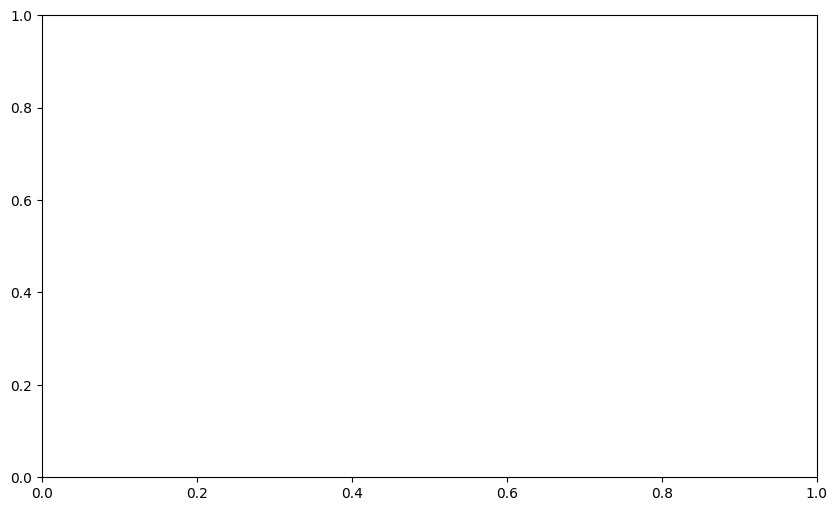

In [9]:
# Load SST2 dataset
dataset = load_dataset("stanfordnlp/sst2")

# Load RoBERTa tokenizer and model
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
model = RobertaForSequenceClassification.from_pretrained("roberta-base", num_labels=2)

# Tokenize datasets
def tokenize_function(examples):
    return tokenizer(examples["sentence"], padding="max_length", truncation=True)

tokenized_datasets = dataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(["idx", "sentence"])
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch")

# Prepare DataLoaders
train_dataloader = DataLoader(tokenized_datasets["train"], shuffle=True, batch_size=16)
eval_dataloader = DataLoader(tokenized_datasets["validation"], batch_size=16)
test_dataloader = DataLoader(tokenized_datasets["test"], batch_size=16)

# Set up optimizer and loss function
optimizer = AdamW(model.parameters(), lr=2e-5)

# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 1
num_training_steps = num_epochs * len(train_dataloader)
eval_steps = 50

train_accuracies = []
eval_accuracies = []

progress_bar = tqdm(range(num_training_steps))

for epoch in range(num_epochs):
    model.train()
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        progress_bar.update(1)

        # Evaluate every eval_steps
        if progress_bar.n % eval_steps == 0:
            model.eval()
            train_correct = 0
            train_total = 0
            eval_correct = 0
            eval_total = 0

            # Evaluate on a subset of training data
            for train_batch in list(train_dataloader)[:len(eval_dataloader)]:
                train_batch = {k: v.to(device) for k, v in train_batch.items()}
                with torch.no_grad():
                    outputs = model(**train_batch)
                predictions = torch.argmax(outputs.logits, dim=-1)
                train_correct += (predictions == train_batch["labels"]).sum().item()
                train_total += train_batch["labels"].size(0)

            # Evaluate on validation set
            for eval_batch in eval_dataloader:
                eval_batch = {k: v.to(device) for k, v in eval_batch.items()}
                with torch.no_grad():
                    outputs = model(**eval_batch)
                predictions = torch.argmax(outputs.logits, dim=-1)
                eval_correct += (predictions == eval_batch["labels"]).sum().item()
                eval_total += eval_batch["labels"].size(0)

            train_accuracy = train_correct / train_total
            eval_accuracy = eval_correct / eval_total

            train_accuracies.append(train_accuracy)
            eval_accuracies.append(eval_accuracy)

            print(f"Step {progress_bar.n}: Train Accuracy: {train_accuracy:.4f}, Eval Accuracy: {eval_accuracy:.4f}")

            model.train()

In [28]:
max(eval_accuracies)

0.948394495412844

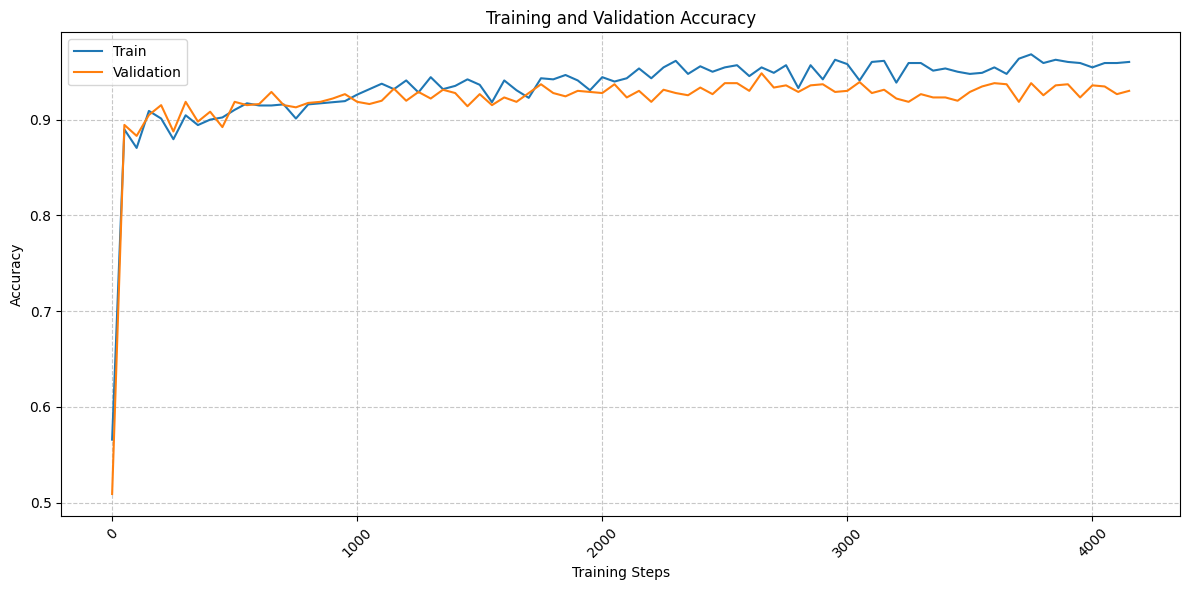

Plot saved as accuracy_plot.png


In [18]:
num_points = len(train_accuracies)
steps = range(0, num_points * 50, 50)  # Assuming eval_steps is 50

plt.figure(figsize=(12, 6))
plt.plot(steps, train_accuracies, label="Train")
plt.plot(steps, eval_accuracies, label="Validation")
plt.xlabel("Training Steps")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()

# Add gridlines
plt.grid(True, linestyle='--', alpha=0.7)

# Improve x-axis readability
plt.xticks(rotation=45)

# Add some padding to the plot
plt.tight_layout()

# Save the plot
plt.savefig("accuracy_plot.png")
plt.show()  # This will display the plot if you're in an interactive environment

print("Plot saved as accuracy_plot.png")

In [26]:
# Print information about the test set
print(f"Number of examples in test set: {len(tokenized_datasets['test'])}")

# Get the feature names
feature_names = tokenized_datasets['test'].column_names
print(f"Features in each example: {feature_names}")

# Display a few examples
print("\nFirst 5 examples from the test set:")
for i in range(5):
    print(f"\nExample {i+1}:")
    for feature in feature_names:
        if feature == 'input_ids':
            # Decode the input_ids to get the original text
            text = tokenizer.decode(tokenized_datasets['test'][i]['input_ids'], skip_special_tokens=True)
            print(f"Decoded text: {text}")
        else:
            print(f"{feature}: {tokenized_datasets['test'][i][feature]}")

# Check unique labels
labels = tokenized_datasets['test']['labels']
unique_labels = torch.unique(labels)
print(f"\nUnique labels in test set: {unique_labels.tolist()}")

# If labels are not all -1, show distribution
if not torch.all(labels == -1):
    label_distribution = [(label.item(), (labels == label).sum().item()) for label in unique_labels]
    print(f"Label distribution: {label_distribution}")

# Check a batch from the dataloader
test_batch = next(iter(test_dataloader))
print("\nSample batch from test_dataloader:")
for k, v in test_batch.items():
    print(f"{k}: shape {v.shape}, dtype {v.dtype}")

# If labels are not all -1 in the batch, show some statistics
if not torch.all(test_batch['labels'] == -1):
    print(f"Unique labels in batch: {torch.unique(test_batch['labels']).tolist()}")
    print(f"Label counts in batch: {[(label.item(), (test_batch['labels'] == label).sum().item()) for label in torch.unique(test_batch['labels'])]}")

Number of examples in test set: 1821
Features in each example: ['labels', 'input_ids', 'attention_mask']

First 5 examples from the test set:

Example 1:
labels: -1
Decoded text: uneasy mishmash of styles and genres.
attention_mask: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [23]:
# Evaluate on test set
model.eval()
test_correct = 0
test_total = 0

for batch in test_dataloader:
    print(f"Labels shape: {batch['labels'].shape}")
    print(f"Labels type: {batch['labels'].dtype}")
    # Print shapes and types of other tensors in the batch as needed
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)
    predictions = torch.argmax(outputs.logits, dim=-1)
    test_correct += (predictions == batch["labels"]).sum().item()
    test_total += batch["labels"].size(0)

Labels shape: torch.Size([16])
Labels type: torch.int64


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
